In [466]:
import pandas as pd
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import numpy as np
import re
from tabula import read_pdf # this is tabula-js, available from pip. you will need to have a JDK installed to use this-- I recommend a quick "brew cask install java" on macos
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime


__Setup__

In [467]:
# URLs from which PDFs will be scraped
pdf_urls = ["http://www.nairobicoffeeexchange.co.ke/index.php?option=com_phocadownload&view=file&id=163:per-month-per-grade-20142015&Itemid=148","http://www.nairobicoffeeexchange.co.ke/index.php?option=com_phocadownload&view=file&id=759:per-month-per-grade-2015-16&Itemid=148","http://www.nairobicoffeeexchange.co.ke/index.php?option=com_phocadownload&view=file&id=2111:per-month-per-grade-20162017&Itemid=148","http://www.nairobicoffeeexchange.co.ke/index.php?option=com_phocadownload&view=file&id=2108:per-month-per-grade-20172018&Itemid=148"]

# path to this script. in this directory you should have the chrome webdriver - 'chromedriver'
filepath = "/users/matt/desktop/resume/specific resumes/rockefeller"

# the css id of the download button on the pages to be scraped
download_button_id = "pdlicensesubmit"

# this is the class of the pdf filename on each of the webpages
filename_class = "pd-document16"

# this is for use down in the reorganization section
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]

__Functions__

In [468]:
# a web scraper class with self-explanatory methods. tailored to this use case.
class Scraper(object):
    def __init__(self):
        self.chromeOptions = webdriver.ChromeOptions()
        
        self.prefs = prefs = {"download.default_directory" : filepath}
        self.chromeOptions.add_experimental_option("prefs",prefs)

        #self.chromeOptions.add_argument("headless") # this is commented out because by default selenium will not download with headless chrome. this can be changed but it's not pressing for our current use case.
        #self.chromeOptions.add_argument("download.default_directory='{}'".format(filepath))
        
        # be sure to place chromedriver in the same directory as this notebook
        # download the appropriate version at http://chromedriver.chromium.org/downloads
        self.browser = webdriver.Chrome(executable_path="{}/chromedriver".format(filepath), chrome_options=self.chromeOptions)
    
    def go_to_page(self, url):
        try:
            self.browser.get(url)
        except Exception as e:
            print("Error getting page:{}".format(e))
            return
        source = self.browser.page_source
        return source
    
    def click_button(self, buttonid):
        button = self.browser.find_element_by_id(buttonid)
        button.click()
        
    def quit_browser(self):
        self.browser.quit()

# this function returns whatever text is inside an element of the specified class. it takes html in string format.
def get_filename(source, class_):
    soup = BeautifulSoup(source)
    item = soup.find(class_=class_)
    return item.text

# a big function highly specialized for our use case, which takes PDFs
# from nairobi coffee exchange and turns them into dataframes.
# it's not pretty and can probably be slicked up.
def pdf_to_dataframe(pdf_filename, months=months):
    # this is from tabula-py
    current_tables = read_pdf(pdf_filename, pages='all', pandas_options={"names":["extra","grade","bags_bought","weight_bought","min_price","max_price","dollar_value","avg_price"]}) # extracts all tables from document

    # here we're creating a 'stringdate' column in which we have nans wherever extra is anything other than dates of format "Month YYYY"
    current_tables['stringdate'] = current_tables['extra']
    current_tables.loc[current_tables['stringdate'].str.contains('|'.join(months)) != True, 'stringdate'] = np.nan

    # we carry forward those values as dates
    current_tables['date'] = pd.to_datetime(current_tables['stringdate'].fillna(method='ffill'), format='%B %Y', errors='coerce')

    # this is because of pdf-reading inconsistency. sometimes the module
    # senses the appropriate columns, and sometimes it adds in extra ones.
    # in the event it's right, the very first cell will be "Date By"
    if (current_tables['extra'][0] != "Date By"):
        # first we need to deal with the stuff on the first page, which reads in badly because of the titles
        # I'm shifting columns over one by one just for the sake of clarity and readability
        current_tables_withnan = current_tables[pd.isna(current_tables['avg_price']) & pd.notna(current_tables['max_price'])]
        current_tables_withnan['avg_price'] = current_tables_withnan['max_price'].str.split(" ", expand=True)[1]
        current_tables_withnan['dollar_value'] = current_tables_withnan['max_price'].str.split(" ", expand=True)[0]
        current_tables_withnan['max_price'] = current_tables_withnan['min_price']
        current_tables_withnan['min_price'] = current_tables_withnan['weight_bought']
        current_tables_withnan['grade'] = current_tables_withnan['extra'].str.split(" ", expand=True)[0]
        current_tables_withnan = current_tables_withnan[3:]

        # append the newly reorganized bits to the rest of the dataset
        full_dataset = current_tables_withnan.append(current_tables[pd.notna(current_tables['avg_price'])]).dropna(subset=['grade'])
    else:
        full_dataset = current_tables[current_tables['extra'] != "Date By"][2:]

    full_dataset = full_dataset[full_dataset['grade'] != "Month"] # removing monthly totals
    full_dataset = full_dataset[full_dataset['bags_bought'] != "Bought"] # removing excess row

    # make columns numeric
    full_dataset['bags_bought'] = full_dataset['bags_bought'].str.replace(',','').astype(float)
    full_dataset['weight_bought'] = full_dataset['weight_bought'].str.replace(',','').astype(float)
    full_dataset['min_price'] = full_dataset['min_price'].str.replace(',','').astype(float)
    full_dataset['max_price'] = full_dataset['max_price'].str.replace(',','').astype(float)
    full_dataset['dollar_value'] = full_dataset['dollar_value'].str.replace(',','').astype(float)
    full_dataset['avg_price'] = full_dataset['avg_price'].str.replace(',','').astype(float)

    # get rid of extra column
    del full_dataset['extra']
    del full_dataset['stringdate']

    return full_dataset

__Fetch Data__

In [469]:
# scrape

full_dataframe = pd.DataFrame()
scrapey = Scraper()

filenames = []

# fetch pdfs in a loop, save filenames
for pdf_url in pdf_urls:
    source = scrapey.go_to_page(pdf_url)
    scrapey.click_button(download_button_id)
    last_downloaded_filename = get_filename(source,filename_class)
    filenames.append(last_downloaded_filename)

# fetch pdfs in a loop (locally), iteratively add to dataframe
for filename in filenames:
    last_dataframe = pdf_to_dataframe(filename)
    full_dataframe = pd.concat([full_dataframe,last_dataframe])

scrapey.quit_browser()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  
/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/usr/local/lib/python3.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't

In [470]:
full_dataframe.to_csv("all_data.csv", encoding='utf-8', index=False)

__Pare down for analysis__

In [471]:
data_for_analysis = pd.read_csv("all_data.csv")

data_for_analysis = full_dataframe[((full_dataframe['grade'] == "AA") | (full_dataframe['grade'] == "AB") | (full_dataframe['grade'] == "C"))]
data_for_analysis = data_for_analysis[['grade','avg_price','date']]

In [472]:
data_for_analysis.head()

,grade,avg_price,date
4,AA,310.71,2014-10-01
5,AB,254.42,2014-10-01
6,C,232.12,2014-10-01
20,AA,300.48,2014-11-01
21,AB,251.45,2014-11-01


__Preliminary Analysis__

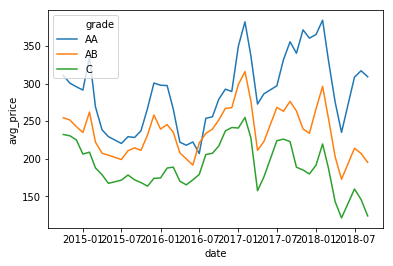

In [473]:
sns.lineplot(x="date", y="avg_price", hue="grade", data=data_for_analysis)

# there's still some missing data here but these look *extremely* correlated.
# seems like maybe what we should do is fit two models: one to forecast
# one grade of coffee into the future, and one correlating that grade
# with the two other grades, and then extrapolating based on that

# implicit assumption: stationarity of the distribution dictating this relationship

In [474]:
# reshape wide so we have only one row for each point in time-- that'll make it easier to see missing data etc.
data_wide = data_for_analysis.pivot_table(values=['avg_price'], index='date', columns='grade', dropna=False).reset_index()
data_wide.columns = data_wide.columns.to_series().str.join('_') # flatten columns

# we're missing June 2015, June 2017 and June 2018

# interpolate missing values. since there's only three, we add them by hand
new_obs1 = {"date_":datetime.strptime("2015-06-1", "%Y-%m-%d"),"avg_price_AA":np.nan,"avg_price_AB":np.nan,"avg_price_C":np.nan}
new_obs2 = {"date_":datetime.strptime("2017-06-1", "%Y-%m-%d"),"avg_price_AA":np.nan,"avg_price_AB":np.nan,"avg_price_C":np.nan}
new_obs3 = {"date_":datetime.strptime("2018-06-1", "%Y-%m-%d"),"avg_price_AA":np.nan,"avg_price_AB":np.nan,"avg_price_C":np.nan}

# is this the best strategy? it should work well enough for now.
data_wide = data_wide.append([new_obs1,new_obs2,new_obs3], ignore_index=True).sort_values(by='date_')
data_wide['avg_price_AA'] = data_wide['avg_price_AA'].interpolate(method='linear')
data_wide['avg_price_AB'] = data_wide['avg_price_AB'].interpolate(method='linear')
data_wide['avg_price_C'] = data_wide['avg_price_C'].interpolate(method='linear')

# using OLS to fit prices AA and AC to AB.
model_AB_AA = sm.OLS(data_wide['avg_price_AA'],data_wide['avg_price_AB']).fit()
model_AB_C = sm.OLS(data_wide['avg_price_C'],data_wide['avg_price_AB']).fit()

In [475]:
model_AB_AA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avg_price_AA   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4005.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           3.80e-47
Time:                        12:36:55   Log-Likelihood:                -233.71
No. Observations:                  48   AIC:                             469.4
Df Residuals:                      47   BIC:                             471.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
avg_price_AB     1.2227      0.019     63.285      0.000       1.184       1.262
==============================================================================
Omnibus:                        5.170   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.440
Skew:                           0.741   Prob(JB):                        0.109
Kurtosis:                       3.162   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [476]:
model_AB_C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            avg_price_C   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     6585.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           3.55e-52
Time:                        12:36:55   Log-Likelihood:                -201.65
No. Observations:                  48   AIC:                             405.3
Df Residuals:                      47   BIC:                             407.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
avg_price_AB     0.8039      0.010     81.150      0.000       0.784       0.824
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   0.426
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.163
Skew:                          -0.096   Prob(JB):                        0.559
Kurtosis:                       2.262   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [477]:
# OK, it looks like our three prices are closely enough correlated that we can just forecast AB for the present use case
# then we'll predict the values of the other two grades after our forecast

__SARIMA__

In [478]:
# Looking at the plot of the data (and just thinking about coffee prices) there's obvious seasonality
# There's also nonstationarity-- a slight downward trend in the data. So we give SARIMA a shot here.
# Obviously this poses problems for my choice to model the relationship between grades via simple OLS
# but with finite resources I think this approach should work just fine

# a more robust model would take greater advantage of the tools available for fitting, describing, etc. (grid search, for example)
# but in this case, especially given time constraints, it seemed to me that a commonsense understanding of the data
# was enough for a serviceable model. I think it looks pretty good!

fit_sarima = sm.tsa.statespace.SARIMAX(endog=data_wide['avg_price_AB'], order=(1,0,1), seasonal_order=(1,1,0,12), trend='c', enforce_invertibility=False).fit()

fit_sarima.summary()


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       avg_price_AB   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -159.948
Date:                            Mon, 25 Mar 2019   AIC                            329.896
Time:                                    12:36:55   BIC                            337.814
Sample:                                         0   HQIC                           332.660
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.0349      4.377     -0.236      0.813      -9.614       7.544
ar.L1          0.7479      0.193      3.866      0.000       0.369       1.127
ma.L1          0.2299      0.231      0.994      0.320      -0.223       0.683
ar.S.L12      -0.3698      0.281     -1.314      0.189      -0.921       0.182
sigma2       389.7798    125.710      3.101      0.002     143.393     636.167
===================================================================================
Ljung-Box (Q):                       37.16   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.37   Prob(JB):                         0.75
Heteroskedasticity (H):               1.27   Skew:                             0.27
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


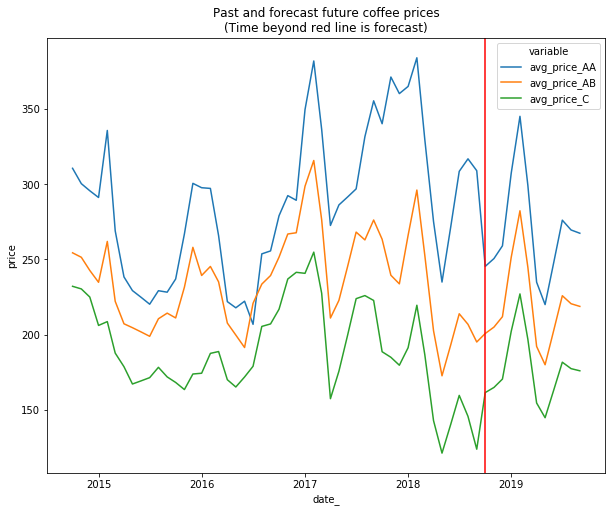

In [479]:
# predict future datapoints, combine with original data

# forecast
future_forecast = fit_sarima.forecast(steps=12)
future_forecast_frame = pd.DataFrame({"date_":pd.date_range(start='2018-10-01', periods=12, freq='MS'),"avg_price_AB":future_forecast}).sort_values('date_')

# predict AA and C
future_forecast_frame['avg_price_AA'] = model_AB_AA.predict(future_forecast_frame['avg_price_AB'])
future_forecast_frame['avg_price_C'] = model_AB_C.predict(future_forecast_frame['avg_price_AB'])

# combine
combined_data = data_wide.append(future_forecast_frame)
combined_data

# melt for plotting ease
combined_data_melted = pd.melt(combined_data, id_vars=['date_'], value_name="price")

# plot
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x="date_", y="price", hue="variable", data=combined_data_melted, legend='brief').set_title("Past and forecast future coffee prices\n(Time beyond red line is forecast)")
plt.axvline('2018-10-01', color='red')



__Basic Descriptive Stats for Writeup__

In [480]:
# mean
future_forecast_frame.aggregate(np.mean)

avg_price_AB    219.690720
avg_price_AA    268.619134
avg_price_C     176.619111
dtype: float64

In [481]:
# max
future_forecast_frame.aggregate(np.max)

date_           2019-09-01 00:00:00
avg_price_AB                282.417
avg_price_AA                345.316
avg_price_C                 227.048
dtype: object

In [482]:
# min
future_forecast_frame.aggregate(np.min)

date_           2018-10-01 00:00:00
avg_price_AB                179.882
avg_price_AA                219.945
avg_price_C                 144.615
dtype: object

In [484]:
# std
future_forecast_frame.aggregate(np.std)

avg_price_AB    28.397681
avg_price_AA    34.722271
avg_price_C     22.830155
dtype: float64